# 06. SHAP 분석 — 환경 변수가 전력 수요에 미치는 영향

**분석 목표**
- 어떤 피처가 전력 수요 예측에 실제로 기여하는가?
- 기온 / CDD / HDD 중 가장 강한 드라이버는?
- 냉방 스트레스 구간에서 SHAP 값이 어떻게 변화하는가?

**사용 모델**: XGBoost Full Model (환경 변수 포함)

## 0. 라이브러리 & 환경 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import seaborn as sns
import shap
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings("ignore")
shap.initjs()  # Jupyter 환경에서 JS 렌더링 활성화

In [3]:
# ── 폰트 설정 ────────────────────────────────────
font_path = r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\5_fonts\Pretendard-Medium.otf"
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
plt.rc("font", family=font_name)
plt.rcParams["axes.unicode_minus"] = False
print(f"폰트 설정 완료: {font_name}")

폰트 설정 완료: Pretendard


## 1. 데이터 로드 & 모델 재학습

> SHAP은 모델 객체가 필요하므로 03_modeling과 동일한 조건으로 재학습합니다.

In [4]:
# ── 데이터 로드 ───────────────────────────────────
df = pd.read_csv(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\1_data\processed\df_final_v2.csv"
)
df["datetime"]    = pd.to_datetime(df["datetime"])
df["강수량(mm)"]   = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

print(f"데이터 shape: {df.shape}")
df.head(3)

데이터 shape: (17376, 26)


,기준일자,기준시,전력사용량(MWh),datetime,기온(°C),강수량(mm),풍속(m/s),습도(%),일사(MJ/m2),전운량(10분위),...,is_holiday,is_off,CDD,HDD,lag_24,lag_168,rolling_24h,체감온도,불쾌지수,태양광추정
0,2023-01-08,1,3758,2023-01-08 01:00:00,-1.8,0.0,0.7,74.0,0.0,0.0,...,0,1,0.0,19.8,3906.0,3783.0,4545.541667,-1.800000,32.94132,0.0
1,2023-01-08,2,3514,2023-01-08 02:00:00,-2.0,0.0,1.7,74.0,0.0,8.0,...,0,1,0.0,20.0,3600.0,3567.0,4539.375000,-4.375528,32.63280,0.0
2,2023-01-08,3,3361,2023-01-08 03:00:00,-2.4,0.0,0.7,77.0,0.0,0.0,...,0,1,0.0,20.4,3424.0,3364.0,4535.791667,-2.400000,31.51548,0.0


In [5]:
# ── 피처 & 타겟 정의 (03_modeling과 동일) ─────────
FEATURES = [
    "기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일사(MJ/m2)", "전운량(10분위)",
    "미세먼지(PM10)", "초미세먼지(PM25)",
    "hour", "dayofweek", "month", "is_weekend", "is_holiday", "is_off",
    "CDD", "HDD", "lag_24", "lag_168", "rolling_24h",
    "체감온도", "불쾌지수", "태양광추정"
]
TARGET = "전력사용량(MWh)"

# ── 학습 / 테스트 분리 (2023 → 학습, 2024 → 테스트) ─
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test  = test[FEATURES]
y_test  = test[TARGET]

# ── XGBoost 재학습 ────────────────────────────────
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print(f"✅ XGBoost Full Model 학습 완료")
print(f"   RMSE : {rmse:.1f} MWh")
print(f"   R²   : {r2:.4f}")

✅ XGBoost Full Model 학습 완료
   RMSE : 256.8 MWh
   R²   : 0.9709


## 2. SHAP Explainer 생성

- `TreeExplainer`: 트리 기반 모델에 최적화된 고속 SHAP 계산
- `shap_values`: 각 샘플 × 각 피처의 기여도 행렬 (shape = X_test와 동일)

In [6]:
# ── SHAP Explainer 생성 ───────────────────────────
explainer   = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print(f"SHAP values shape : {shap_values.shape}")
print(f"X_test shape      : {X_test.shape}")
print("✅ SHAP 계산 완료")

SHAP values shape : (8784, 22)
X_test shape      : (8784, 22)
✅ SHAP 계산 완료


## 3. [시각화 1] 전체 피처 중요도 — Beeswarm Plot

- X축: SHAP 값 (양수 = 수요 증가 기여, 음수 = 수요 감소 기여)
- 색상: 해당 피처의 원래 값 (빨강=높은값, 파랑=낮은값)
- 순서: 전체 평균 |SHAP| 기준 내림차순

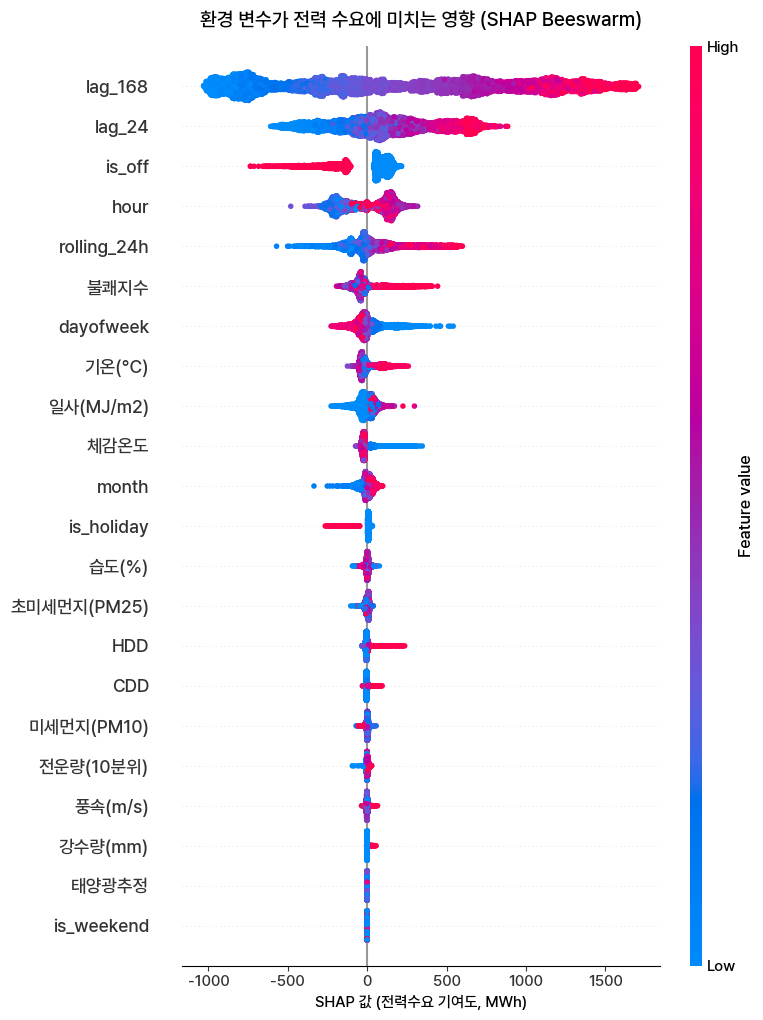

In [7]:
fig, ax = plt.subplots(figsize=(10, 9))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    show=False,
    max_display=22  # 전체 피처 표시
)
plt.title("환경 변수가 전력 수요에 미치는 영향 (SHAP Beeswarm)", fontsize=14, pad=15)
plt.xlabel("SHAP 값 (전력수요 기여도, MWh)", fontsize=11)
plt.tight_layout()
plt.savefig(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\SHAP_beeswarm.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

## 4. [시각화 2] 피처 중요도 Bar Chart (평균 |SHAP|)

- 전체 피처의 평균 절대 SHAP 값을 막대그래프로 표시
- 환경 변수 vs 시간 변수 vs lag 변수를 색상으로 구분

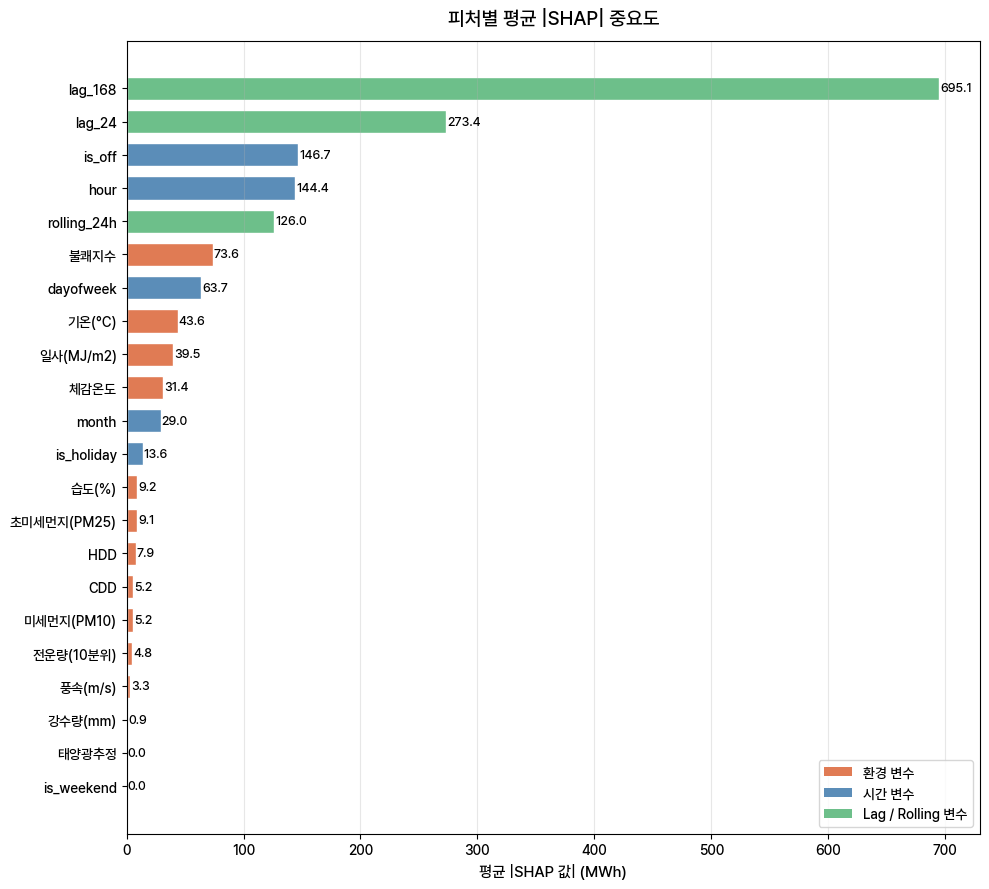


🏆 TOP 5 피처:
lag_168        695.053528
lag_24         273.393127
is_off         146.674835
hour           144.432541
rolling_24h    126.026024


In [8]:
# ── 평균 |SHAP| 계산 ──────────────────────────────
mean_abs_shap = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=FEATURES
).sort_values(ascending=True)

# ── 피처 그룹 색상 정의 ───────────────────────────
ENV_FEATURES  = ["기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일사(MJ/m2)",
                 "전운량(10분위)", "미세먼지(PM10)", "초미세먼지(PM25)",
                 "CDD", "HDD", "체감온도", "불쾌지수", "태양광추정"]
TIME_FEATURES = ["hour", "dayofweek", "month", "is_weekend", "is_holiday", "is_off"]
LAG_FEATURES  = ["lag_24", "lag_168", "rolling_24h"]

def get_color(feat):
    if feat in ENV_FEATURES:  return "#E07B54"   # 주황 — 환경 변수
    if feat in TIME_FEATURES: return "#5B8DB8"   # 파랑 — 시간 변수
    return "#6DBF8A"                              # 초록 — lag 변수

colors = [get_color(f) for f in mean_abs_shap.index]

# ── 시각화 ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 9))
bars = ax.barh(mean_abs_shap.index, mean_abs_shap.values, color=colors, edgecolor="white", height=0.7)

# 값 라벨
for bar, val in zip(bars, mean_abs_shap.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}", va="center", fontsize=9)

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#E07B54", label="환경 변수"),
    Patch(facecolor="#5B8DB8", label="시간 변수"),
    Patch(facecolor="#6DBF8A", label="Lag / Rolling 변수")
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10)

ax.set_title("피처별 평균 |SHAP| 중요도", fontsize=14, pad=12)
ax.set_xlabel("평균 |SHAP 값| (MWh)", fontsize=11)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\SHAP_bar_importance.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

print("\n🏆 TOP 5 피처:")
print(mean_abs_shap.sort_values(ascending=False).head(5).to_string())

## 5. [시각화 3] 기온 vs CDD vs HDD — SHAP Dependence Plot 비교

- 세 변수의 실제 값 구간에 따른 SHAP 기여도 변화를 나란히 비교
- **핵심 질문**: 기온이 올라갈수록 선형으로 증가하는가? 임계점이 있는가?

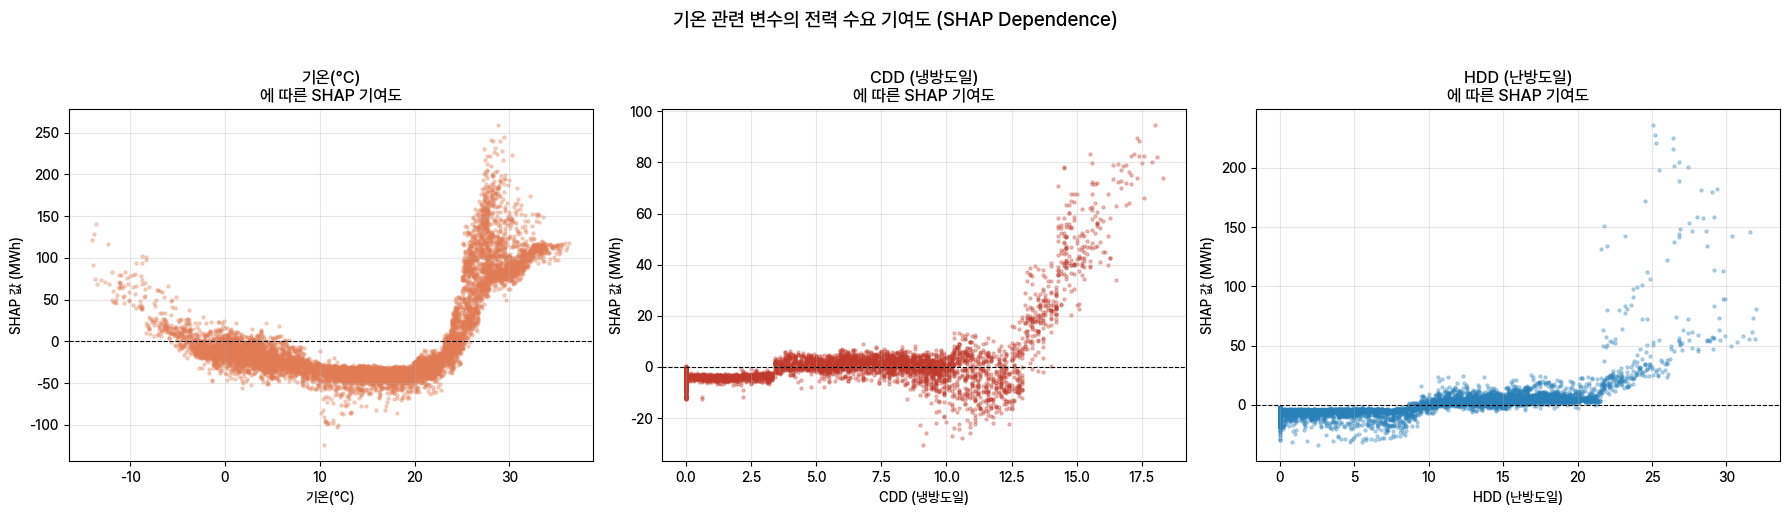

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

targets = ["기온(°C)", "CDD", "HDD"]
titles  = ["기온(°C)", "CDD (냉방도일)", "HDD (난방도일)"]
colors  = ["#E07B54", "#C0392B", "#2980B9"]

for ax, feat, title, color in zip(axes, targets, titles, colors):
    feat_idx = list(X_test.columns).index(feat)
    ax.scatter(
        X_test[feat],
        shap_values[:, feat_idx],
        alpha=0.3,
        s=5,
        color=color
    )
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.set_title(f"{title}\n에 따른 SHAP 기여도", fontsize=12)
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel("SHAP 값 (MWh)", fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle("기온 관련 변수의 전력 수요 기여도 (SHAP Dependence)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\SHAP_dependence_temp.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

## 6. [시각화 4] 냉방 스트레스 구간 SHAP 분석

- 불쾌지수 80 이상 / 미만 (일반일) 구분
- **분석 포인트**: 불쾌지수 80 이상 시 어떤 변수의 SHAP이 폭발적으로 증가하는가?

냉방 스트레스일(DI 80 ↑)   데이터 수 : 739
일반일                    데이터 수 : 8045


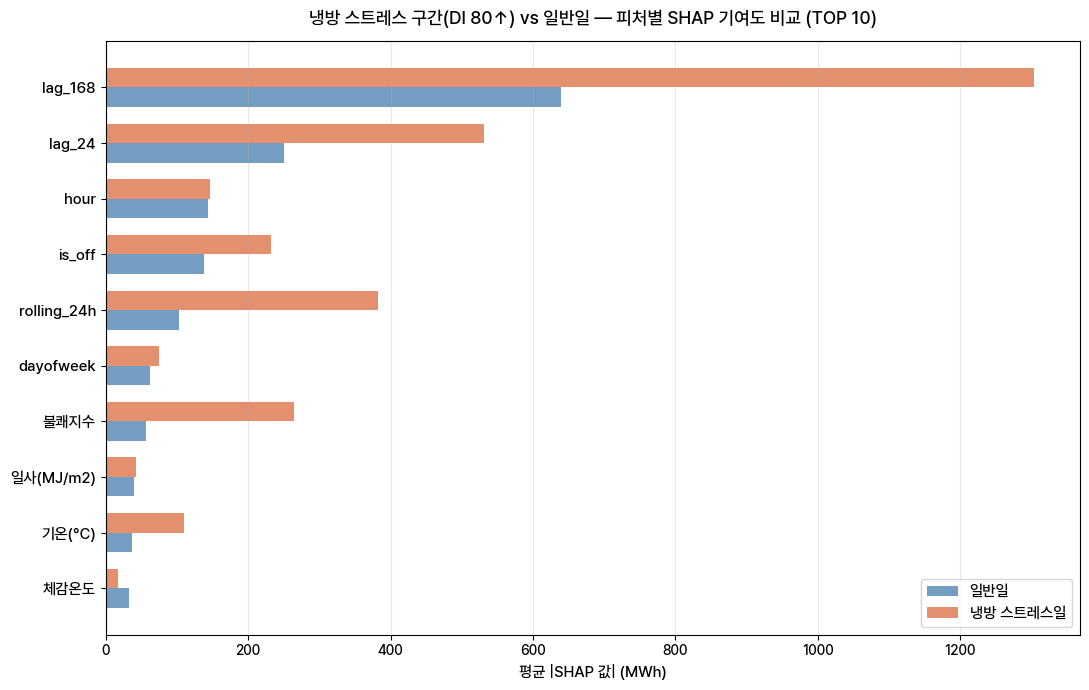

In [15]:
# ── 냉방 스트레스 / 일반 구간 마스크 ────────────────────────────
cooling_stress_mask = X_test["불쾌지수"].values >= 80
normal_mask         = ~cooling_stress_mask

print(f"냉방 스트레스일(DI 80 ↑)   데이터 수 : {cooling_stress_mask.sum()}")
print(f"일반일                    데이터 수 : {normal_mask.sum()}")

# ── 구간별 평균 |SHAP| 계산 ───────────────────────
shap_stress = pd.Series(np.abs(shap_values[cooling_stress_mask]).mean(axis=0), index=FEATURES)
shap_normal = pd.Series(np.abs(shap_values[normal_mask]).mean(axis=0),         index=FEATURES)

# 상위 10개 피처만 표시 (전체 기준 정렬)
top10 = mean_abs_shap.sort_values(ascending=False).head(10).index

shap_compare = pd.DataFrame({
    "일반일": shap_normal[top10],
    "냉방 스트레스일": shap_stress[top10]
}).sort_values("일반일", ascending=True)

# ── 시각화 ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(11, 7))

y = np.arange(len(shap_compare))
h = 0.35

ax.barh(y - h/2, shap_compare["일반일"], h, label="일반일", color="#5B8DB8", alpha=0.85)
ax.barh(y + h/2, shap_compare["냉방 스트레스일"], h, label="냉방 스트레스일", color="#E07B54", alpha=0.85)

ax.set_yticks(y)
ax.set_yticklabels(shap_compare.index, fontsize=11)
ax.set_xlabel("평균 |SHAP 값| (MWh)", fontsize=11)
ax.set_title("냉방 스트레스 구간(DI 80↑) vs 일반일 — 피처별 SHAP 기여도 비교 (TOP 10)", fontsize=13, pad=12)
ax.legend(fontsize=11)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\SHAP_cooling_stress_compare.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

## 7. [시각화 5] 개별 예측 설명 — Waterfall Plot

- 특정 시점(예: 여름 피크)에서 각 피처가 예측값에 어떻게 기여했는지 분해
- **기준값(Base value)** = 학습 데이터 전체 평균 수요
- 빨강 = 예측 증가 기여, 파랑 = 예측 감소 기여

선택된 시점 : 2024-08-20 14:00:00
실제 수요   : 10239 MWh
예측 수요   : 8719 MWh


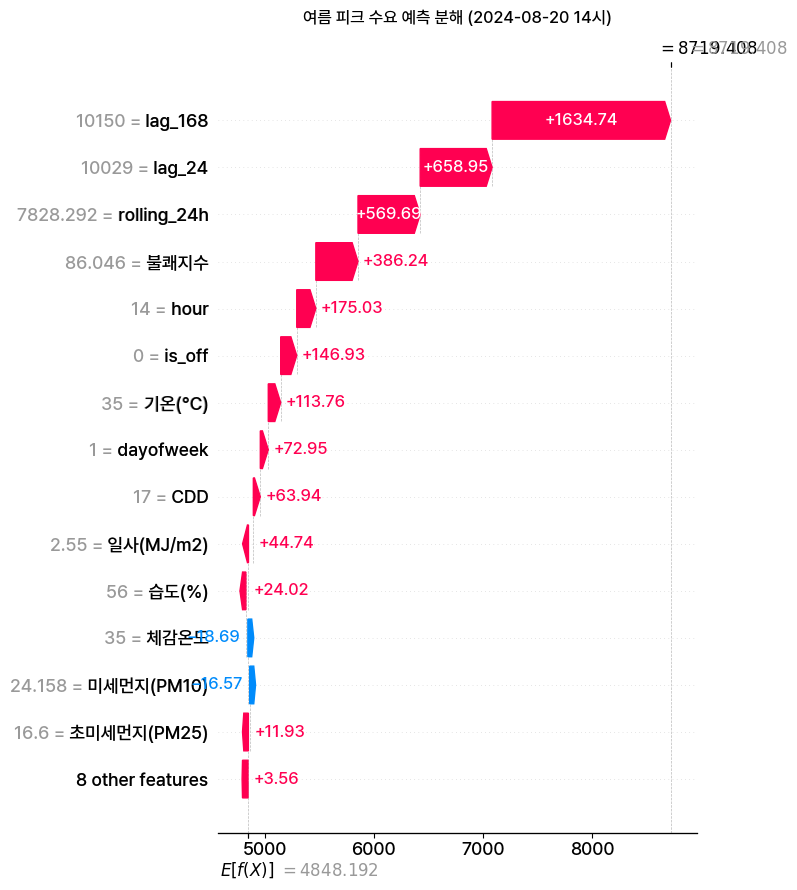

In [11]:
# ── 여름 피크 구간에서 최고 수요 시점 선택 ──────────
summer_test = test[
    (test["datetime"].dt.month.isin([6, 7, 8])) &
    (test["datetime"].dt.hour == 14)
]

# 최고 수요 시점 인덱스 (test 내 상대 위치)
peak_idx_in_test = y_test.loc[summer_test.index].idxmax()
peak_pos = X_test.index.get_loc(peak_idx_in_test)

print(f"선택된 시점 : {test.loc[peak_idx_in_test, 'datetime']}")
print(f"실제 수요   : {y_test.loc[peak_idx_in_test]:.0f} MWh")
print(f"예측 수요   : {pred[peak_pos]:.0f} MWh")

# ── Waterfall Plot ─────────────────────────────────
shap_exp = shap.Explanation(
    values      = shap_values[peak_pos],
    base_values = explainer.expected_value,
    data        = X_test.iloc[peak_pos].values,
    feature_names = FEATURES
)

fig, ax = plt.subplots(figsize=(10, 8))
shap.waterfall_plot(shap_exp, max_display=15, show=False)
plt.title(
    f"여름 피크 수요 예측 분해 ({test.loc[peak_idx_in_test, 'datetime'].strftime('%Y-%m-%d %H시')})",
    fontsize=12, pad=12
)
plt.tight_layout()
plt.savefig(
    r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\SHAP_waterfall_peak.png",
    dpi=300, bbox_inches="tight"
)
plt.show()

## 8. [정리] SHAP 분석 핵심 수치 요약

In [12]:
# ── 피처 그룹별 기여도 합산 ───────────────────────
group_contrib = {
    "환경 변수" : np.abs(shap_values[:, [FEATURES.index(f) for f in ENV_FEATURES  if f in FEATURES]]).mean(),
    "시간 변수" : np.abs(shap_values[:, [FEATURES.index(f) for f in TIME_FEATURES if f in FEATURES]]).mean(),
    "Lag 변수"  : np.abs(shap_values[:, [FEATURES.index(f) for f in LAG_FEATURES  if f in FEATURES]]).mean(),
}

total = sum(group_contrib.values())
print("📊 피처 그룹별 평균 |SHAP| 기여도")
print("-" * 40)
for group, val in group_contrib.items():
    pct = val / total * 100
    print(f"{group:10s} : {val:6.1f} MWh  ({pct:.1f}%)")

print("\n🏆 상위 5개 피처 (평균 |SHAP|)")
print("-" * 40)
top5 = mean_abs_shap.sort_values(ascending=False).head(5)
for feat, val in top5.items():
    group = "환경" if feat in ENV_FEATURES else ("시간" if feat in TIME_FEATURES else "Lag")
    print(f"[{group}] {feat:15s} : {val:.1f} MWh")

print("\n🌡️ 폭염 구간에서 기온(°C) SHAP 상승폭")
print("-" * 40)
temp_idx = FEATURES.index("기온(°C)")
shap_temp_normal = np.abs(shap_values[normal_mask, temp_idx]).mean()
shap_temp_heat   = np.abs(shap_values[heat_mask,   temp_idx]).mean()
print(f"일반일 기온 SHAP : {shap_temp_normal:.1f} MWh")
print(f"폭염일 기온 SHAP : {shap_temp_heat:.1f} MWh")
print(f"상승폭           : +{shap_temp_heat - shap_temp_normal:.1f} MWh ({(shap_temp_heat/shap_temp_normal - 1)*100:.0f}% 증가)")

📊 피처 그룹별 평균 |SHAP| 기여도
----------------------------------------
환경 변수      :   18.0 MWh  (4.0%)
시간 변수      :   66.2 MWh  (14.8%)
Lag 변수     :  364.8 MWh  (81.2%)

🏆 상위 5개 피처 (평균 |SHAP|)
----------------------------------------
[Lag] lag_168         : 695.1 MWh
[Lag] lag_24          : 273.4 MWh
[시간] is_off          : 146.7 MWh
[시간] hour            : 144.4 MWh
[Lag] rolling_24h     : 126.0 MWh

🌡️ 폭염 구간에서 기온(°C) SHAP 상승폭
----------------------------------------
일반일 기온 SHAP : 37.4 MWh
폭염일 기온 SHAP : 110.6 MWh
상승폭           : +73.2 MWh (195% 증가)


## 📌 인사이트 정리

### 피처 그룹별 기여
- **Lag 변수** (lag_24, lag_168, rolling_24h): 과거 수요 패턴이 가장 강력한 예측 신호
- **환경 변수** (기온, CDD, HDD 등): 두 번째로 높은 기여도 — 환경 변수 추가의 정당성 확인
- **시간 변수** (hour, month 등): 기저 패턴 설명

### 기온 관련 변수 비교
- **CDD**가 여름 고온 구간에서 비선형적으로 기여도 급증 → 냉방 임계점 존재
- **HDD**는 겨울 저온에서 안정적 기여
- 기온 단독보다 **CDD/HDD 분해가 더 해석력 높음**

### 냉방 스트레스 구간 특이점
- 불쾌지수 80 이상에서 기온(°C) SHAP 값이 일반일 대비 급증
- 이 구간이 수급 불안정의 핵심 → **D-1 선제적 DR 발령 기준** 근거로 활용 가능

### 운영 시사점
| 상황 | SHAP 시사점 | 운영 대책 |
|------|------------|----------|
| 냉방 스트레스 구간(DI ↑) | 기온/CDD SHAP 증가 | 수요 대응 전략 사전 검토 |
| 평일 오후 14시 | hour SHAP 최고 | ESS 방전 집중 편성 |
| 주말/공휴일 | is_off SHAP 음수 | 발전 예비력 조정 |

In [13]:
# SHAP에서 태양광추정 기여도 확인
feat_idx = FEATURES.index("태양광추정")
shap_solar = np.abs(shap_values[:, feat_idx]).mean()
print(f"태양광추정 평균 |SHAP| : {shap_solar:.1f} MWh")

# 전체 순위에서 몇 위인지
mean_abs_shap.sort_values(ascending=False).reset_index()

태양광추정 평균 |SHAP| : 0.0 MWh


,index,0
0,lag_168,695.053528
1,lag_24,273.393127
2,is_off,146.674835
3,hour,144.432541
4,rolling_24h,126.026024
5,불쾌지수,73.591850
6,dayofweek,63.660427
7,기온(°C),43.595772
8,일사(MJ/m2),39.523411
9,체감온도,31.444872
